In [1]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool, cpu_count
import cv2

In [2]:
dfAll = pd.read_pickle("PklData/AllData.pkl")
dfAll.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
0,3,1545216073822,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
1,3,1545216073826,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
2,3,1545216073867,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
3,3,1545216073911,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."
4,3,1545216073945,0,34,0,0,0,False,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 1, ..."


In [3]:
df_actual = dfAll[(dfAll.Actual_Data == True) & (dfAll.Is_Pause == False)]
df_actual.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
9921,3,1545216477388,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9922,3,1545216477425,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9923,3,1545216477464,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9924,3,1545216477504,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
9925,3,1545216477545,1,680,10,2,0,True,False,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, ..."


In [4]:
print("all: %s, actual data: %s" % (len(dfAll), len(df_actual)))

all: 453710, actual data: 381231


In [5]:
"""%%time
# this will be the faster repetition check
def is_max(row):
    return row.RepetitionID == df_filtered[(df_filtered.userID == row.userID) & (df_filtered.TaskID == row.TaskID) & (df_filtered.VersionID == row.VersionID)].RepetitionID.max()

pool = Pool(8)
df_filtered = df_actual.copy(deep=True)

max_vals = pool.map(is_max, [row for index, row in df_filtered.iterrows()])
df_filtered["IsMax"] = max_vals
print(df_filtered.head())
pool.close()"""

'%%time\n# this will be the faster repetition check\ndef is_max(row):\n    return row.RepetitionID == df_filtered[(df_filtered.userID == row.userID) & (df_filtered.TaskID == row.TaskID) & (df_filtered.VersionID == row.VersionID)].RepetitionID.max()\n\npool = Pool(8)\ndf_filtered = df_actual.copy(deep=True)\n\nmax_vals = pool.map(is_max, [row for index, row in df_filtered.iterrows()])\ndf_filtered["IsMax"] = max_vals\nprint(df_filtered.head())\npool.close()'

In [6]:
%%time
df_filtered = df_actual.copy(deep=True)
for User in df_filtered.userID.unique():
    print(User)
    for Task in df_filtered.TaskID.unique():
        for Version in df_filtered.VersionID.unique():
            max_rep = df_filtered[(df_filtered.userID == User) & (df_filtered.TaskID == Task) & (df_filtered.VersionID == Version)].RepetitionID.max()
            df_filtered = df_filtered.drop(df_filtered[(df_filtered.userID == User) & (df_filtered.TaskID == Task) & (df_filtered.VersionID == Version) & (df_filtered.RepetitionID != max_rep)].index)

3
7
5
6
2
4
1
8
CPU times: user 11min 57s, sys: 9.3 s, total: 12min 7s
Wall time: 12min 6s


In [7]:
df_filtered.to_pickle("PklData/dfFiltered.pkl")

In [8]:
df_filtered = pd.read_pickle("PklData/dfFiltered.pkl")

In [9]:
print("actual: %s, filtered data: %s" % (len(df_actual), len(df_filtered)))

actual: 381231, filtered data: 275596


In [10]:
def detect_blobs(index, row):
    image = row.Image
    image = image.reshape(27, 15)
    temp, thresh = cv2.threshold(cv2.bitwise_not(image), 200, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    if len(contours) > 0:
        if (row.TaskID not in [6, 7, 23, 24]):
            # only one blob
            contours.sort(key=lambda a: cv2.contourArea(a))
            max_contour = contours[-1]
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            croped_im = np.zeros((27,15))
            blob = image[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])]
            croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
            return (1, [croped_im])
        else:
            # two blobs
            blobs = []
            for i in range(1, 2):
                contours.sort(key=lambda a: cv2.contourArea(a))
                max_contour = contours[-1 * i]
                xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
                xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
                croped_im = np.zeros((27,15))
                blob = image[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])]
                croped_im[0:blob.shape[0],0:blob.shape[1]] = blob
                blobs.append(blobs)
            return (2, blobs)
    else:
        return (0, np.zeros((27,15)))

In [11]:
%%time
pool = Pool(cpu_count())
df_croped = df_filtered.copy()
temp_blobs = pool.starmap(detect_blobs, df_filtered.iterrows())
df_croped["BlobCount"] = [a[0] for a in temp_blobs]
df_croped["Blobs"] = [a[1] for a in temp_blobs]
df_croped.head()

CPU times: user 1min 10s, sys: 4.96 s, total: 1min 15s
Wall time: 1min 17s


In [12]:
df_blobs = df_croped[df_croped.BlobCount >= 1]
print("detected blobs: %s" % len(df_blobs))
df_blobs.head()

detected blobs: 71895


,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image,BlobCount,Blobs
10000,3,1545216480595,1,680,10,2,0,True,False,"[0, 227, 191, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",1,"[[[3.0, 2.0, 8.0, 8.0, 3.0, 0.0, 0.0, 0.0, 0.0..."
10004,3,1545216480764,1,680,10,2,0,True,False,"[0, 227, 191, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",1,"[[[0.0, 0.0, 4.0, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0..."
10005,3,1545216480809,1,680,10,2,0,True,False,"[0, 227, 191, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",1,"[[[0.0, 4.0, 6.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0..."
10006,3,1545216480845,1,680,10,2,0,True,False,"[0, 227, 191, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",1,"[[[0.0, 4.0, 6.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0..."
10007,3,1545216480886,1,680,10,2,0,True,False,"[0, 227, 191, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...",1,"[[[0.0, 4.0, 6.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0..."


In [13]:
df_blobs.to_pickle("PklData/df_blobs_gestures.pkl")

# Build Gestures

In [17]:
def detect_and_return_blobs(row):
    image = row[1].Image
    image = image.reshape(27, 15)
    temp, thresh = cv2.threshold(cv2.bitwise_not(image), 200, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    if len(contours) > 0:
        if (row[1].TaskID not in [6, 7, 23, 24]):
            # only one blob
            contours.sort(key=lambda a: cv2.contourArea(a))
            max_contour = contours[-1]
            xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
            xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
            croped_im = np.zeros((27,15))
            blob = image[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])]
            croped_im[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])] = blob
            return [croped_im]
        else:
            # two blobs
            blobs = []
            for i in range(1, 2):
                contours.sort(key=lambda a: cv2.contourArea(a))
                max_contour = contours[-1 * i]
                xmax, ymax = np.max(max_contour.reshape(len(max_contour),2), axis=0)
                xmin, ymin = np.min(max_contour.reshape(len(max_contour),2), axis=0)
                croped_im = np.zeros((27,15))
                blob = image[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])]
                croped_im[max(ymin - 1, 0):min(ymax + 1, image.shape[0]),max(xmin - 1, 0):min(xmax + 1, image.shape[1])] = blob
                blobs.append(croped_im)
            return blobs
    else:
        return np.zeros((27,15))

In [18]:
%%time
data_points = []

for UserID in df_blobs.userID.unique():
    print(UserID)
    for TaskID in df_blobs[df_blobs.userID == UserID].TaskID.unique():
        for VersionID in df_blobs[(df_blobs.userID == UserID) & (df_blobs.TaskID == TaskID)].VersionID.unique():
            for RepetitionID in df_blobs[(df_blobs.userID == UserID) & (df_blobs.TaskID == TaskID) & (df_blobs.VersionID == VersionID)].RepetitionID.unique():
                data = df_blobs[(df_blobs.userID == UserID) & (df_blobs.TaskID == TaskID) & (df_blobs.VersionID == VersionID) & (df_blobs.RepetitionID == RepetitionID)]
                gesture_im = np.zeros((27,15))
                for row in data.iterrows():
                    blobs = detect_and_return_blobs(row)
                    for blob in blobs:
                        gesture_im = gesture_im + blob
                #gesture_im = np.clip(gesture_im, 0, 255)
                data_points.append([UserID, TaskID, VersionID, RepetitionID, gesture_im])

print(len(data_points))

3
7
5
6
2
4
1
8
4397
CPU times: user 1min, sys: 436 ms, total: 1min
Wall time: 1min


In [19]:
df_gestures = pd.DataFrame(data_points)
df_gestures.columns = ["userID", "TaskID", "VersionID", "RepetitionID", "Gesture"]
df_gestures.head()

,userID,TaskID,VersionID,RepetitionID,Gesture
0,3,10,2,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,3,10,3,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3,10,4,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,3,10,5,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,3,10,6,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [20]:
df_gestures.to_pickle("PklData/df_gestures.pkl")

# display Gesture

<Figure size 432x288 with 0 Axes>

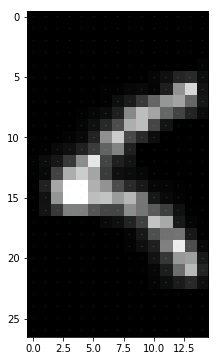

In [21]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = 2500
data = df_gestures.Gesture.iloc[data_point]
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
# plt.savefig("input.png", bbox_inches='tight')
plt.show()